# L5: Automate Event Planning

In this lesson, you will learn more about Tasks.

The libraries are already installed in the classroom. If you're running this notebook on your own machine, you can install the following:
```Python
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29
```

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

- Import libraries, APIs and LLM

In [2]:
from crewai import Agent, Crew, Task

**Note**: 
- The video uses `gpt-4-turbo`, but due to certain constraints, and in order to offer this course for free to everyone, the code you'll run here will use `gpt-3.5-turbo`.
- You can use `gpt-4-turbo` when you run the notebook _locally_ (using `gpt-4-turbo` will not work on the platform)
- Thank you for your understanding!

In [3]:
import os
from utils import get_openai_api_key,get_serper_api_key

openai_api_key = get_openai_api_key()
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'
os.environ["SERPER_API_KEY"] = get_serper_api_key()

## crewAI Tools

In [4]:
from crewai_tools import ScrapeWebsiteTool, SerperDevTool

# Initialize the tools
search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()

## Creating Agents

In [5]:
# Agent 1: Venue Coordinator
venue_coordinator = Agent(
    role="Venue Coordinator",
    goal="Identify and book an appropriate venue "
    "based on event requirements",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "With a keen sense of space and "
        "understanding of event logistics, "
        "you excel at finding and securing "
        "the perfect venue that fits the event's theme, "
        "size, and budget constraints."
    )
)

In [6]:
 # Agent 2: Logistics Manager
logistics_manager = Agent(
    role='Logistics Manager',
    goal=(
        "Manage all logistics for the event "
        "including catering and equipmen"
    ),
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Organized and detail-oriented, "
        "you ensure that every logistical aspect of the event "
        "from catering to equipment setup "
        "is flawlessly executed to create a seamless experience."
    )
)

In [7]:
# Agent 3: Marketing and Communications Agent
marketing_communications_agent = Agent(
    role="Marketing and Communications Agent",
    goal="Effectively market the event and "
         "communicate with participants",
    tools=[search_tool, scrape_tool],
    verbose=True,
    backstory=(
        "Creative and communicative, "
        "you craft compelling messages and "
        "engage with potential attendees "
        "to maximize event exposure and participation."
    )
)

## Creating Venue Pydantic Object

- Create a class `VenueDetails` using [Pydantic BaseModel](https://docs.pydantic.dev/latest/api/base_model/).
- Agents will populate this object with information about different venues by creating different instances of it.

In [8]:
from pydantic import BaseModel
# Define a Pydantic model for venue details 
# (demonstrating Output as Pydantic)
class VenueDetails(BaseModel):
    name: str
    address: str
    capacity: int
    booking_status: str

So this is a very interesting use case, and how you can use agents
to transfer the fuzzy outputs into actual
strongly typed outputs that you can use in your regular code.


Pydantic,It's a library that has been getting a lot of attention.
Allows you to create models in work
with strong typed up variables in a very easy way.
So you can see here that instead of like what you would do
with classic Python, where you would declare a class
and then you would need to declare a niche method and in that method you woul
need to receive a bunch of arguments and then set a bunch of variables.
It gets away from all of that and creates this syntactic sugar that allows you to create models in a very simple way.


So now it's not only a class that you're creating, but you're creating a model or research
that has attributes without having to go through the hassle
ali-nishe mathod and setting them up individually.


## Creating Tasks
- By using `output_json`, you can specify the structure of the output you want.
- By using `output_file`, you can get your output in a file.
- By setting `human_input=True`, the task will ask for human feedback (whether you like the results or not) before finalising it.

In [9]:
venue_task = Task(
    description="Find a venue in {event_city} "
                "that meets criteria for {event_topic}.",
    expected_output="All the details of a specifically chosen"
                    "venue you found to accommodate the event.",
    human_input=True,
    output_json=VenueDetails,
    output_file="venue_details.json",  
      # Outputs the venue details as a JSON file
    agent=venue_coordinator
)

- By setting `async_execution=True`, it means the task can run in parallel with the tasks which come after it.

In [10]:
logistics_task = Task(
    description="Coordinate catering and "
                 "equipment for an event "
                 "with {expected_participants} participants "
                 "on {tentative_date}.",
    expected_output="Confirmation of all logistics arrangements "
                    "including catering and equipment setup.",
    human_input=True,
    async_execution=True,
    agent=logistics_manager
)

In [11]:
marketing_task = Task(
    description="Promote the {event_topic} "
                "aiming to engage at least"
                "{expected_participants} potential attendees.",
    expected_output="Report on marketing activities "
                    "and attendee engagement formatted as markdown.",
    async_execution=True,
    output_file="marketing_report.md",  # Outputs the report as a text file
    agent=marketing_communications_agent
)

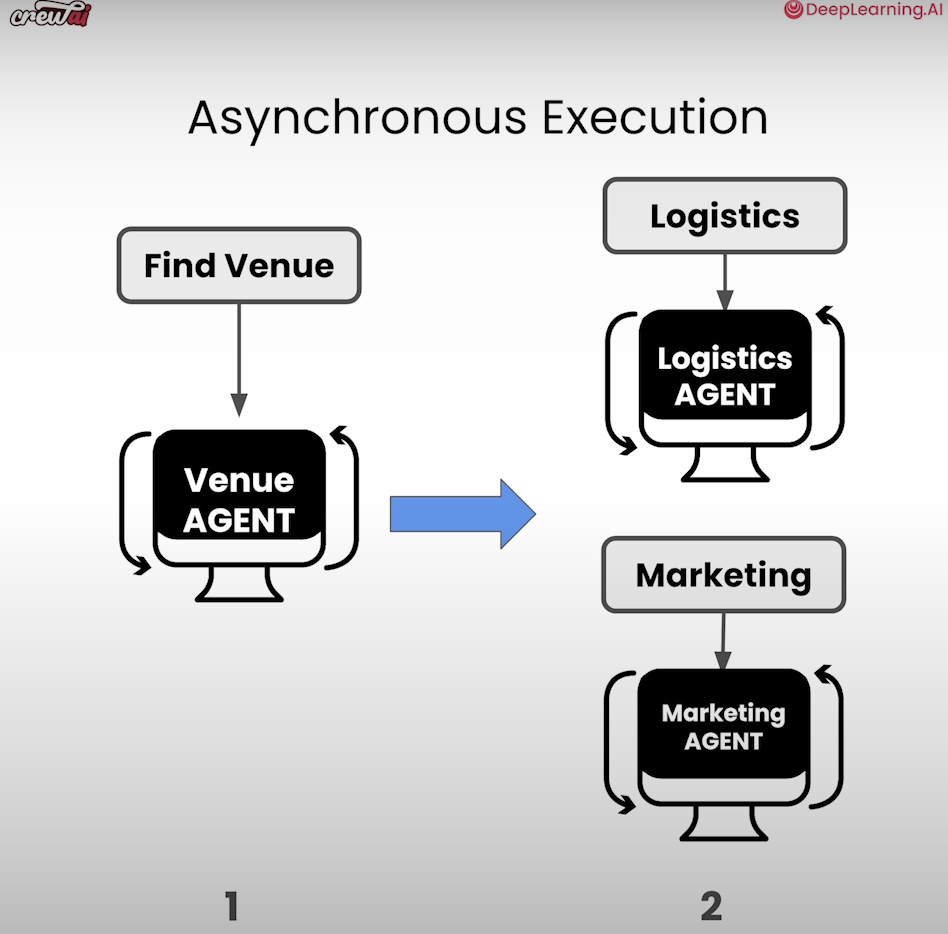

So what that means is that the first task,
the task that selects the venue, it's going to be executed by itself, alone.
As all the other tasks that it have been that we have seen so far.
Then after that, the logistics tasks and the marketing tasks
are going to be executed in parallel.
Because if you think about it, one doesn't rely on the other.
The output of the logistic task doesn't necessarily matter
for the marketing tasks to occur.
So we can have them run in parallel without too much trouble.
And here we can see that we are outputting the result of the marketing
task into a file, and in this case is a markdown file.
And because in the expected output, we are mentioning that
we expect the result to be formatted as markdown.

## Creating the Crew

**Note**: Since you set `async_execution=True` for `logistics_task` and `marketing_task` tasks, now the order for them does not matter in the `tasks` list.

In [12]:
# Define the crew with agents and tasks
event_management_crew = Crew(
    agents=[venue_coordinator, 
            logistics_manager, 
            marketing_communications_agent],
    
    tasks=[venue_task, 
           logistics_task, 
           marketing_task],
    
    verbose=True
)

## Running the Crew

- Set the inputs for the execution of the crew.

In [13]:
event_details = {
    'event_topic': "Tech Innovation Conference",
    'event_description': "A gathering of tech innovators "
                         "and industry leaders "
                         "to explore future technologies.",
    'event_city': "San Francisco",
    'tentative_date': "2024-09-15",
    'expected_participants': 500,
    'budget': 20000,
    'venue_type': "Conference Hall"
}

**Note 1**: LLMs can provide different outputs for they same input, so what you get might be different than what you see in the video.

**Note 2**: 
- Since you set `human_input=True` for some tasks, the execution will ask for your input before it finishes running.
- When it asks for feedback, use your mouse pointer to first click in the text box before typing anything.

In [14]:
result = event_management_crew.kickoff(inputs=event_details)

 [DEBUG]: == Working Agent: Venue Coordinator
 [INFO]: == Starting Task: Find a venue in San Francisco that meets criteria for Tech Innovation Conference.


> Entering new CrewAgentExecutor chain...
I need to carefully consider the requirements for the Tech Innovation Conference and find a venue in San Francisco that meets all the criteria.

Action: Search the internet
Action Input: {"search_query": "Tech Innovation Conference venues in San Francisco"} 


Search results: Title: Top 12 tech conferences in San Francisco for 2024 - TravelPerk
Link: https://www.travelperk.com/blog/top-tech-conferences-in-san-francisco/
Snippet: Top 12 tech conferences in San Francisco for 2024 · Developer Week · Women Impact Tech · SaaS Connect · Cybersecurity and Cloud Congress · Startup ...
---
Title: Top 16 Must-Visit San Francisco Tech Events in 2024
Link: https://startupvoyager.com/tech-events-san-francisco/
Snippet: 1. Tech Summit Silicon Valley ... Tech Summit Silicon Valley is an immersive two-day 

 [DEBUG]: == [Venue Coordinator] Task output: {
  "name": "San Francisco Marriott Marquis",
  "address": "780 Mission Street, San Francisco, CA 94103",
  "capacity": 0,
  "booking_status": "Unavailable"
}


 [DEBUG]: == Working Agent: Logistics Manager
 [INFO]: == Starting Task: Coordinate catering and equipment for an event with 500 participants on 2024-09-15.
 [DEBUG]: == [Logistics Manager] Task output: {
  "name": "San Francisco Marriott Marquis",
  "address": "780 Mission Street, San Francisco, CA 94103",
  "capacity": 0,
  "booking_status": "Unavailable"
}


 [DEBUG]: == Working Agent: Marketing and Communications Agent
 [INFO]: == Starting Task: Promote the Tech Innovation Conference aiming to engage at least500 potential attendees.
 [DEBUG]: == [Marketing and Communications Agent] Task output: {
  "name": "San Francisco Marriott Marquis",
  "address": "780 Mission Street, San Francisco, CA 94103",
  "capacity": 0,
  "booking_status": "Unavailable"
}




> Entering new CrewAgent

Thought: I need to gather information on potential attendees and effectively market the Tech Innovation Conference.

Action: Search the internet
Action Input: {"search_query": "Tech Innovation Conference 2024 potential attendees"} 


Search results: Title: Top 20 Tech Conferences to Attend in 2024 - InEvent
Link: https://inevent.com/blog/others/top-20-tech-conferences-to-attend-in-2024.html
Snippet: The year 2024 promises an exciting lineup of conferences where attendees ... This premier tech conference attracts over 101,000 attendees ...
---
Title: Tech Conferences: The Best Tech Events Guide for 2024 - Bizzabo
Link: https://www.bizzabo.com/blog/technology-events
Snippet: Conference highlights include 5,000 attendees, a $5M pitch competition, 6 innovation studio tracks, thought leaders from across the globe, over 200 speakers ...
---
Title: Insurance Tech & Innovation Conference | June 12 - 13, 2024 - USA
Link: https://events.altaworld.tech/Insurance-Tech-Innovation-Conference.html
Sn

Exception in thread Thread-5 (_execute):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "/usr/local/lib/python3.11/threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.11/site-packages/crewai/task.py", line 182, in _execute
    result = agent.execute_task(
             ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/crewai/agent.py", line 221, in execute_task
    result = self.agent_executor.invoke(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/site-packages/langchain/chains/base.py", line 163, in invoke
    raise e
  File "/usr/local/lib/python3.11/site-packages/langchain/chains/base.py", line 153, in invoke
    self._call(inputs, run_manager=run_manager)
  File "/us

 


Search results: Title: TechConnect World 2024
Link: https://techconnectworld.com/
Snippet: TechConnect World 2024 will take place June 17-19, 2024, Washington DC, Gaylord National Harbor.
---
Title: Top 20 Tech Conferences to Attend in 2024 - InEvent
Link: https://inevent.com/blog/others/top-20-tech-conferences-to-attend-in-2024.html
Snippet: The AI & Big Data Expo, organized by TechEx Media Ltd, is scheduled for June 5-6, 2024, at the Santa Clara Convention Center, CA, USA. This ...
---
Title: Top Innovation Conferences of 2024 - Seed Strategy
Link: https://seedstrategy.com/brand-building/top-innovation-conferences-of-2024/
Snippet: Top Innovation Conferences of 2024 · Expo West (March 12-16) Anaheim, California · Shoptalk (March 17-24) Las Vegas, Nevada · American Food Innovate Summit (March ...
---
Title: 2024 Innovations in Technology Conference | LSC
Link: https://www.lsc.gov/events/events/2024-innovations-technology-conference
Snippet: The conference featured over 50 workshop

Thought: I need to gather information on potential attendees and effectively market the Tech Innovation Conference.

Action: Search the internet
Action Input: {"search_query": "Tech Innovation Conference 2024 potential attendees"} 


Search results: Title: Top 20 Tech Conferences to Attend in 2024 - InEvent
Link: https://inevent.com/blog/others/top-20-tech-conferences-to-attend-in-2024.html
Snippet: The year 2024 promises an exciting lineup of conferences where attendees ... This premier tech conference attracts over 101,000 attendees ...
---
Title: Tech Conferences: The Best Tech Events Guide for 2024 - Bizzabo
Link: https://www.bizzabo.com/blog/technology-events
Snippet: Conference highlights include 5,000 attendees, a $5M pitch competition, 6 innovation studio tracks, thought leaders from across the globe, over 200 speakers ...
---
Title: Insurance Tech & Innovation Conference | June 12 - 13, 2024 - USA
Link: https://events.altaworld.tech/Insurance-Tech-Innovation-Conference.html
Sn

Thought: I need to gather information on potential attendees and effectively market the Tech Innovation Conference.

Action: Search the internet
Action Input: {"search_query": "Tech Innovation Conference 2024 potential attendees"} 


Search results: Title: Top 20 Tech Conferences to Attend in 2024 - InEvent
Link: https://inevent.com/blog/others/top-20-tech-conferences-to-attend-in-2024.html
Snippet: The year 2024 promises an exciting lineup of conferences where attendees ... This premier tech conference attracts over 101,000 attendees ...
---
Title: Tech Conferences: The Best Tech Events Guide for 2024 - Bizzabo
Link: https://www.bizzabo.com/blog/technology-events
Snippet: Conference highlights include 5,000 attendees, a $5M pitch competition, 6 innovation studio tracks, thought leaders from across the globe, over 200 speakers ...
---
Title: Insurance Tech & Innovation Conference | June 12 - 13, 2024 - USA
Link: https://events.altaworld.tech/Insurance-Tech-Innovation-Conference.html
Sn

Thought: I need to gather information on potential attendees and effectively market the Tech Innovation Conference.

Action: Search the internet
Action Input: {"search_query": "Tech Innovation Conference 2024 potential attendees"} 


Search results: Title: Top 20 Tech Conferences to Attend in 2024 - InEvent
Link: https://inevent.com/blog/others/top-20-tech-conferences-to-attend-in-2024.html
Snippet: The year 2024 promises an exciting lineup of conferences where attendees ... This premier tech conference attracts over 101,000 attendees ...
---
Title: Tech Conferences: The Best Tech Events Guide for 2024 - Bizzabo
Link: https://www.bizzabo.com/blog/technology-events
Snippet: Conference highlights include 5,000 attendees, a $5M pitch competition, 6 innovation studio tracks, thought leaders from across the globe, over 200 speakers ...
---
Title: Insurance Tech & Innovation Conference | June 12 - 13, 2024 - USA
Link: https://events.altaworld.tech/Insurance-Tech-Innovation-Conference.html
Sn

Thought: I need to gather information on potential attendees and effectively market the Tech Innovation Conference.

Action: Search the internet
Action Input: {"search_query": "Tech Innovation Conference 2024 potential attendees"} 


Search results: Title: Top 20 Tech Conferences to Attend in 2024 - InEvent
Link: https://inevent.com/blog/others/top-20-tech-conferences-to-attend-in-2024.html
Snippet: The year 2024 promises an exciting lineup of conferences where attendees ... This premier tech conference attracts over 101,000 attendees ...
---
Title: Tech Conferences: The Best Tech Events Guide for 2024 - Bizzabo
Link: https://www.bizzabo.com/blog/technology-events
Snippet: Conference highlights include 5,000 attendees, a $5M pitch competition, 6 innovation studio tracks, thought leaders from across the globe, over 200 speakers ...
---
Title: Insurance Tech & Innovation Conference | June 12 - 13, 2024 - USA
Link: https://events.altaworld.tech/Insurance-Tech-Innovation-Conference.html
Sn

- Display the generated `venue_details.json` file.

In [15]:
import json
from pprint import pprint

with open('venue_details.json') as f:
   data = json.load(f)

pprint(data)

{'address': '780 Mission Street, San Francisco, CA 94103',
 'booking_status': 'Unavailable',
 'capacity': 0,
 'name': 'San Francisco Marriott Marquis'}


- Display the generated `marketing_report.md` file.

**Note**: After `kickoff` execution has successfully ran, wait an extra 45 seconds for the `marketing_report.md` file to be generated. If you try to run the code below before the file has been generated, your output would look like:

```
marketing_report.md
```

If you see this output, wait some more and than try again.

In [16]:
from IPython.display import Markdown
Markdown("marketing_report.md")

marketing_report.md

In [1]:
print("hi")

hi


In [2]:
s = "https://plantcopilotstorageacct.blob.core.windows.net/advisor/f3627551-608f-44ee-a3d4-d8ace85e0a12/input/GINA. Global strategy for asthma management and prevention. 2022.pdf?sv=2023-11-03&se=2025-04-01T10%3A30%3A47Z&sr=b&sp=r&sig=idvAOydONbCwWsSoo0Xdl3A6AK3JZ5bl6tFsMp94hAM%3D"

In [3]:
s.split('/')[6].split('.')[1].split('?')[0]

' Global strategy for asthma management and prevention'

In [7]:
s.split('/')[6].split('.')

['GINA',
 ' Global strategy for asthma management and prevention',
 ' 2022',
 'pdf?sv=2023-11-03&se=2025-04-01T10%3A30%3A47Z&sr=b&sp=r&sig=idvAOydONbCwWsSoo0Xdl3A6AK3JZ5bl6tFsMp94hAM%3D']